In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.densenet import preprocess_input

# Load and prepare the dataset

In [2]:
batch_size = 16
img_height = 224
img_width = 224

In [3]:
data_dir = "D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE"
data_dir = pathlib.Path(data_dir)
list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'), shuffle=False)
list_ds = list_ds.shuffle(len(list_ds), reshuffle_each_iteration=False)
image_count = len(list_ds)
print(image_count)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

30007
24006
6001


In [4]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])


def process_path(file_path):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [5]:
def data_augmentation(batch, blur_range=(0.0, 0.2*255.0), noise_range=(0.0, 0.2*255.0)):
    # Apply random Gaussian blur and noise to each image in the batch
    def augment_image(image):
        # Apply Gaussian blur with random severity within `blur_range`
        blur_sigma = np.random.uniform(*blur_range)
        image = tfa.image.gaussian_filter2d(image, filter_shape=(3, 3), sigma=blur_sigma)

        # Add Gaussian noise with random severity within `noise_range`
        noise_scale = np.random.uniform(*noise_range)
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_scale)
        image = tf.add(image, noise)

        return image

    augmented_batch = tf.map_fn(augment_image, batch)
    return augmented_batch

In [6]:
train_ds = train_ds.batch(batch_size)

# Extract one batch and apply data augmentation and data preprocessing to it

In [8]:
batch_ = next(iter(train_ds))[0]
augmented_batch_ = data_augmentation(batch_)
preprocessed_augmented_batch = preprocess_input(augmented_batch_)

In [10]:
def show_batch(image_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        plt.subplot(4, 4, n + 1)
        # if the image is a tensor, convert it to a numpy array
        if isinstance(image_batch[n], tf.Tensor):
            plt.imshow(image_batch[n].numpy().astype("uint8"))
        else:
            plt.imshow(image_batch[n].astype("uint8"))
        plt.axis("off")

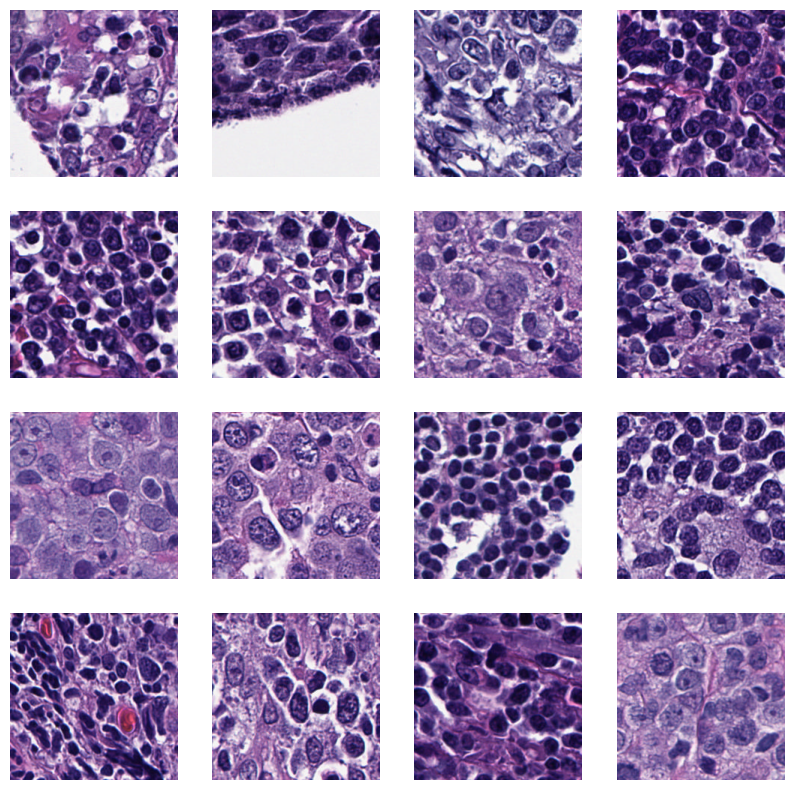

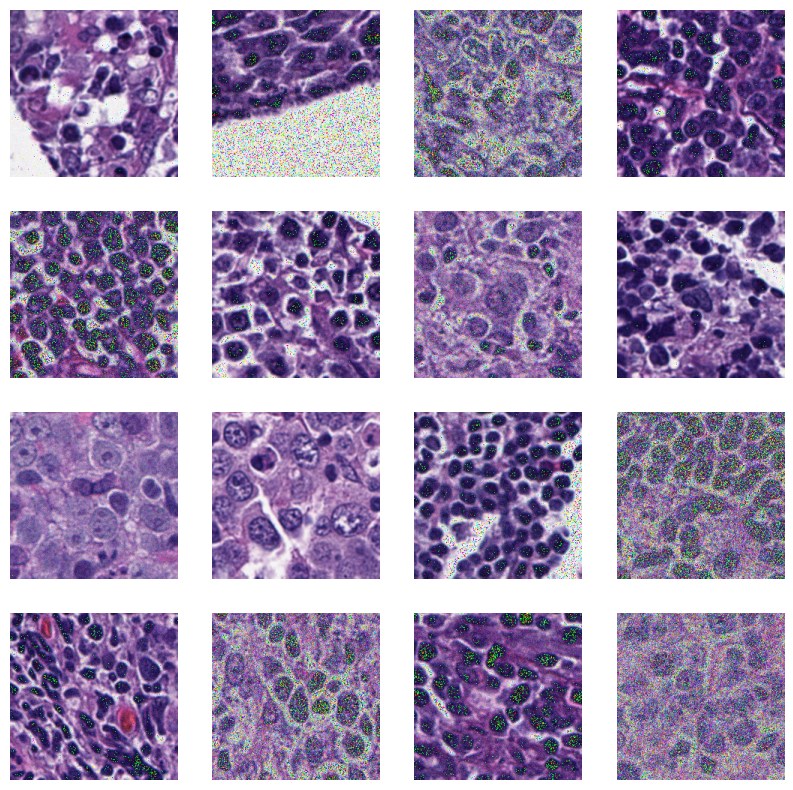

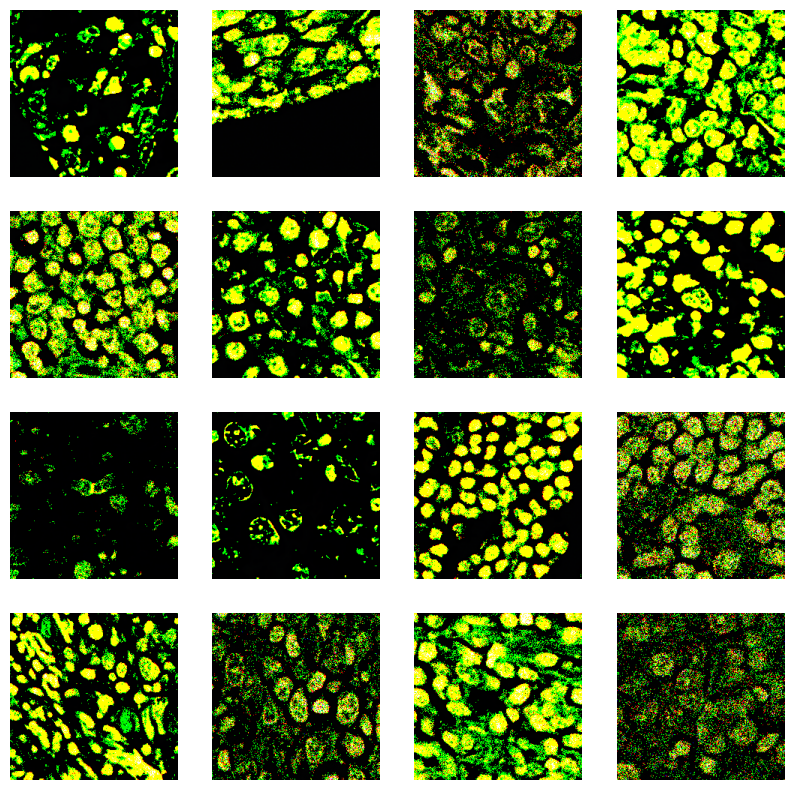

In [11]:
show_batch(batch_)
show_batch(augmented_batch_)
show_batch(preprocessed_augmented_batch)

# Load the model and show the output for the corresponding batch

In [32]:
model = tf.keras.models.load_model("../Models/Model_16_1e-05_19042023_093832/2")

In [34]:
output_batch = model.predict(preprocessed_augmented_batch)

1/1 [==============================] - 0s 308ms/step


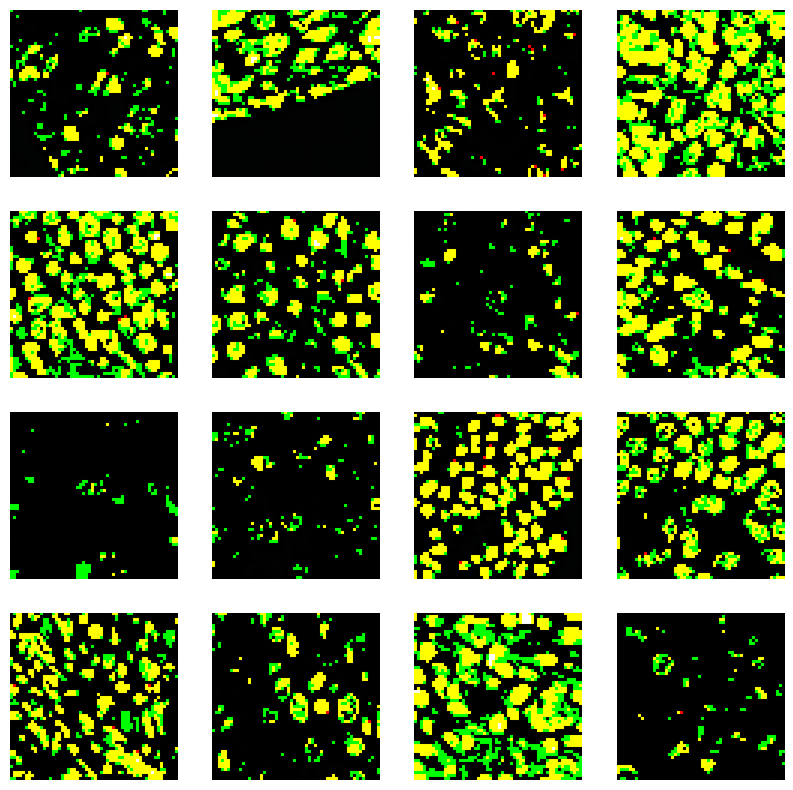

In [35]:
show_batch(output_batch)

In [36]:
# rescale the output to the range [0, 255]
output_batch = (output_batch - output_batch.min()) / (output_batch.max() - output_batch.min())
output_batch = output_batch * 255

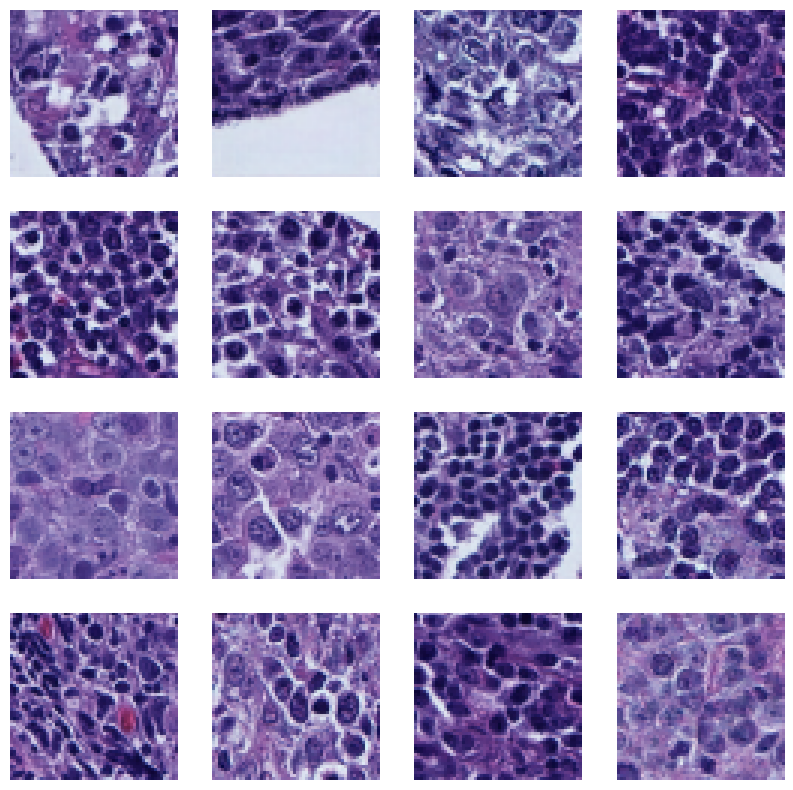

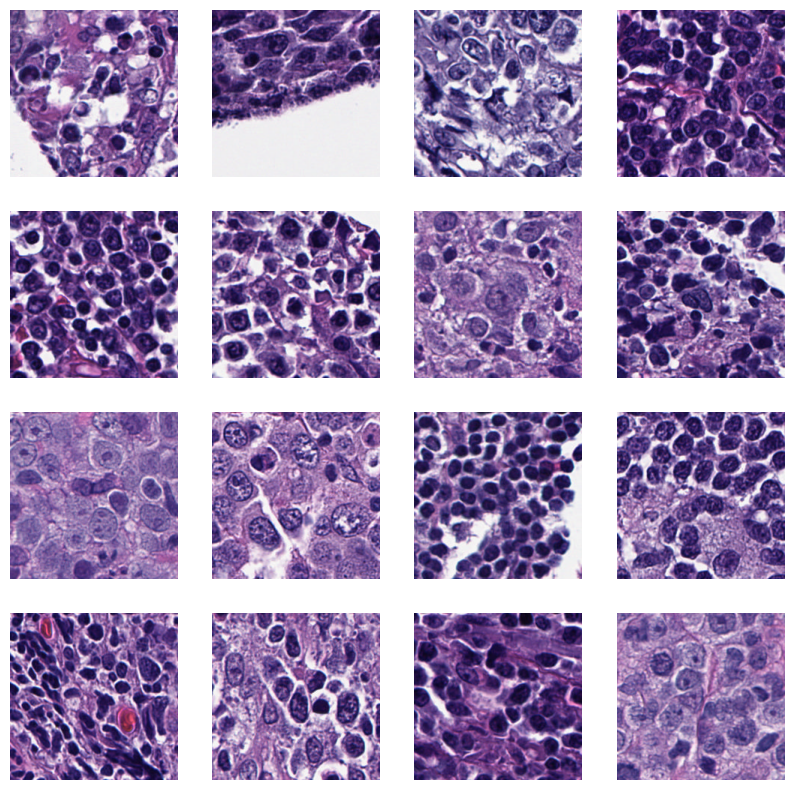

In [37]:
show_batch(output_batch)
show_batch(batch_)

# Show the extracted features from the output layer of the encoder part

In [38]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
ae_feature_extractor = Model(inputs=model.layers[-2].inputs, outputs=GlobalAveragePooling2D()(model.layers[-2].outputs[-1]))

In [40]:
batch_features = ae_feature_extractor.predict(preprocessed_augmented_batch)

1/1 [==============================] - 0s 46ms/step


In [41]:
# Convert batch_features into a pandas dataframe
import pandas as pd
df = pd.DataFrame(batch_features)

In [42]:
df = df.rename(columns={i: f"feature_{i}" for i in range(len(df.columns))})
df = df.rename(index={i: f"patch_{i}" for i in range(16)})

In [43]:
df

feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
patch_0    0.079058   0.101839   0.038714   0.001197   0.157684   0.577292   
patch_1    0.131054   0.279291   0.013522   0.014268   0.097224   0.388883   
patch_2    0.105498   0.043900   0.093133   0.026836   0.229651   0.238579   
patch_3    0.101339   0.071045   0.046367   0.137694   0.080903   1.226789   
patch_4    0.102719   0.047529   0.075246   0.061137   0.136281   1.257985   
patch_5    0.088618   0.053771   0.086025   0.032240   0.029869   0.463347   
patch_6    0.077279   0.093206   0.049708   0.007215   0.299801   0.649159   
patch_7    0.093621   0.087254   0.056750   0.049053   0.065985   0.128379   
patch_8    0.056792   0.047420   0.048829   0.002456   0.504833   0.130137   
patch_9    0.070840   0.054413   0.113985   0.000000   0.333591   0.000000   
patch_10   0.095030   0.100945   0.010031   0.015172   0.091165   0.403136   
patch_11   0.108374   0.087107   0.112707   0.034110   0.156264   1.119602   
patch_12   0.087329   0.055491   0.026285   0.132477   0.101457   0.199601   
patch_13   0.089438   0.046606   0.053294   0.032772   0.208056   0.955330   
patch_14   0.101216   0.066622   0.026360   0.105112   0.155859   1.704057   
patch_15   0.089439   0.099626   0.081351   0.004559   0.466316   0.904253   

          feature_6  feature_7  feature_8  feature_9  ...  feature_1014  \
patch_0    0.049568   0.154618   0.468245   0.026688  ...      1.479260   
patch_1    0.038233   0.149112   1.769596   0.051071  ...      4.714393   
patch_2    0.049223   0.153793   0.314068   0.001739  ...      0.000000   
patch_3    0.078185   0.155254   0.048928   0.047744  ...      0.829959   
patch_4    0.073673   0.153454   0.390567   0.014609  ...      0.201464   
patch_5    0.049424   0.155120   0.217939   0.035999  ...      0.000000   
patch_6    0.066951   0.152933   0.264829   0.010306  ...      3.419016   
patch_7    0.066478   0.155800   0.221433   0.100775  ...      0.000000   
patch_8    0.075716   0.149774   0.095100   0.013022  ...      8.117817   
patch_9    0.049513   0.153537   0.105902   0.017386  ...      6.677276   
patch_10   0.085615   0.153347   0.483005   0.018145  ...      2.689402   
patch_11   0.062008   0.152895   0.473504   0.000423  ...      0.215089   
patch_12   0.065544   0.156980   0.143215   0.068758  ...      0.000000   
patch_13   0.062633   0.154189   0.311710   0.001312  ...      0.028320   
patch_14   0.074373   0.154498   0.183703   0.062375  ...      0.163930   
patch_15   0.079404   0.150827   0.692511   0.002209  ...      0.278072   

          feature_1015  feature_1016  feature_1017  feature_1018  \
patch_0       1.937722      2.823339      2.730105      0.552729   
patch_1      14.058155      0.068701      6.208028      6.417749   
patch_2       0.000000      1.629776      3.190407      0.244187   
patch_3       0.000000      3.044750      0.062503      1.860562   
patch_4       0.012203      1.825754      0.311114      0.045708   
patch_5       0.656764      1.351592      0.428882      0.438831   
patch_6       0.404774      0.913656      6.456297      2.887594   
patch_7       0.016496      1.088195      0.794281      0.155579   
patch_8       4.395434      3.974613      9.505091      0.015006   
patch_9       2.383368      2.296713      4.926644      0.000000   
patch_10      0.479996      2.397181      0.358864      0.084655   
patch_11      0.000000      5.587970      0.253774      1.198249   
patch_12      0.365586      1.221368      0.574459      0.061536   
patch_13      0.002677      2.054280      4.371090      1.563954   
patch_14      0.000000      3.012320      0.000000      0.111302   
patch_15      0.000000      4.260124      1.368025      0.246909   

          feature_1019  feature_1020  feature_1021  feature_1022  feature_1023  
patch_0       2.828326      1.628604      0.972940      3.598855      0.441718  
patch_1      12.390990      8.606631      5.157099     10.757438      0.097401  
patch_2